In [125]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [126]:
path = 'minimal_pkls/'
save_path = 'phi_stats/'
os.makedirs(save_path, exist_ok=True)
files = os.listdir(path)
len(files)

200

In [259]:
from social_phi import get_signal, experiment_hop_range

def flatten(l : list):
    return [item for sublist in l for item in sublist]

def run_experiment(file, time_scale=24*3600, window=30):
    if os.path.exists(save_path + file[:-4] + '.csv'):
        return
    
    data = pickle.load(open(path + file, 'rb'))
    sig = get_signal(data['activities'], time_scale=time_scale, binarize=True)
    stats = experiment_hop_range(sig=sig, window=window, min_hop=1, max_hop=window, silent=True)
    stats.to_csv(save_path + file[:-4] + '.csv', index=False)
    
def load_data(file):
    stats = pd.read_csv(save_path + file)
    data = pickle.load(open(path + file[:-4] + '.pkl', 'rb'))
    act = flatten(data['activities'].values())
    
    return {
        'forks' : data['forks'],
        'stars' : data['stars'],
        'issues' : data['issues'],
        'users' : len(data['activities']),
        'avg_commit' : len(act) / len(data['activities']),
        'total_commits' : len(act),
        'timeline_length' : (max(act) - min(act)) // (24*3600),
        'avg_phi' : stats.loc[np.argmax(stats['avg_phi']*stats['vnr'])].avg_phi
    }

In [7]:
from joblib import Parallel, delayed

_ = Parallel(n_jobs=20)(delayed(extract_data)(file) for file in tqdm(files))

  0%|          | 0/200 [00:00<?, ?it/s]

In [260]:
df = pd.DataFrame(columns=['forks', 'stars', 'issues', 'users', 'avg_commit', 'total_commits', 'timeline_length', 'avg_phi'])
for file in os.listdir(save_path):
    df = df.append(load_data(file), ignore_index=True)
df = df.astype(float)
print(df.shape)
df.describe()

(200, 8)


,forks,stars,issues,users,avg_commit,total_commits,timeline_length,avg_phi
count,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,7310.725000,34761.095000,763.85500,626.325000,32.828833,10420.275000,2897.120000,0.965668
std,8987.707573,32779.152061,990.46492,837.297933,57.893841,5509.547699,1182.043621,0.167907
min,719.000000,15237.000000,0.00000,11.000000,2.455188,1520.000000,414.000000,0.529599
25%,2934.000000,18782.000000,164.50000,247.000000,13.526999,6215.250000,2127.000000,0.845013
50%,4426.500000,24287.500000,500.00000,455.500000,21.496770,8448.000000,2737.000000,0.939325
75%,7774.500000,37941.500000,919.75000,714.500000,33.734695,13560.750000,3599.250000,1.073508
max,73734.000000,325401.000000,9213.00000,9618.000000,586.708333,27770.000000,7847.000000,1.408350


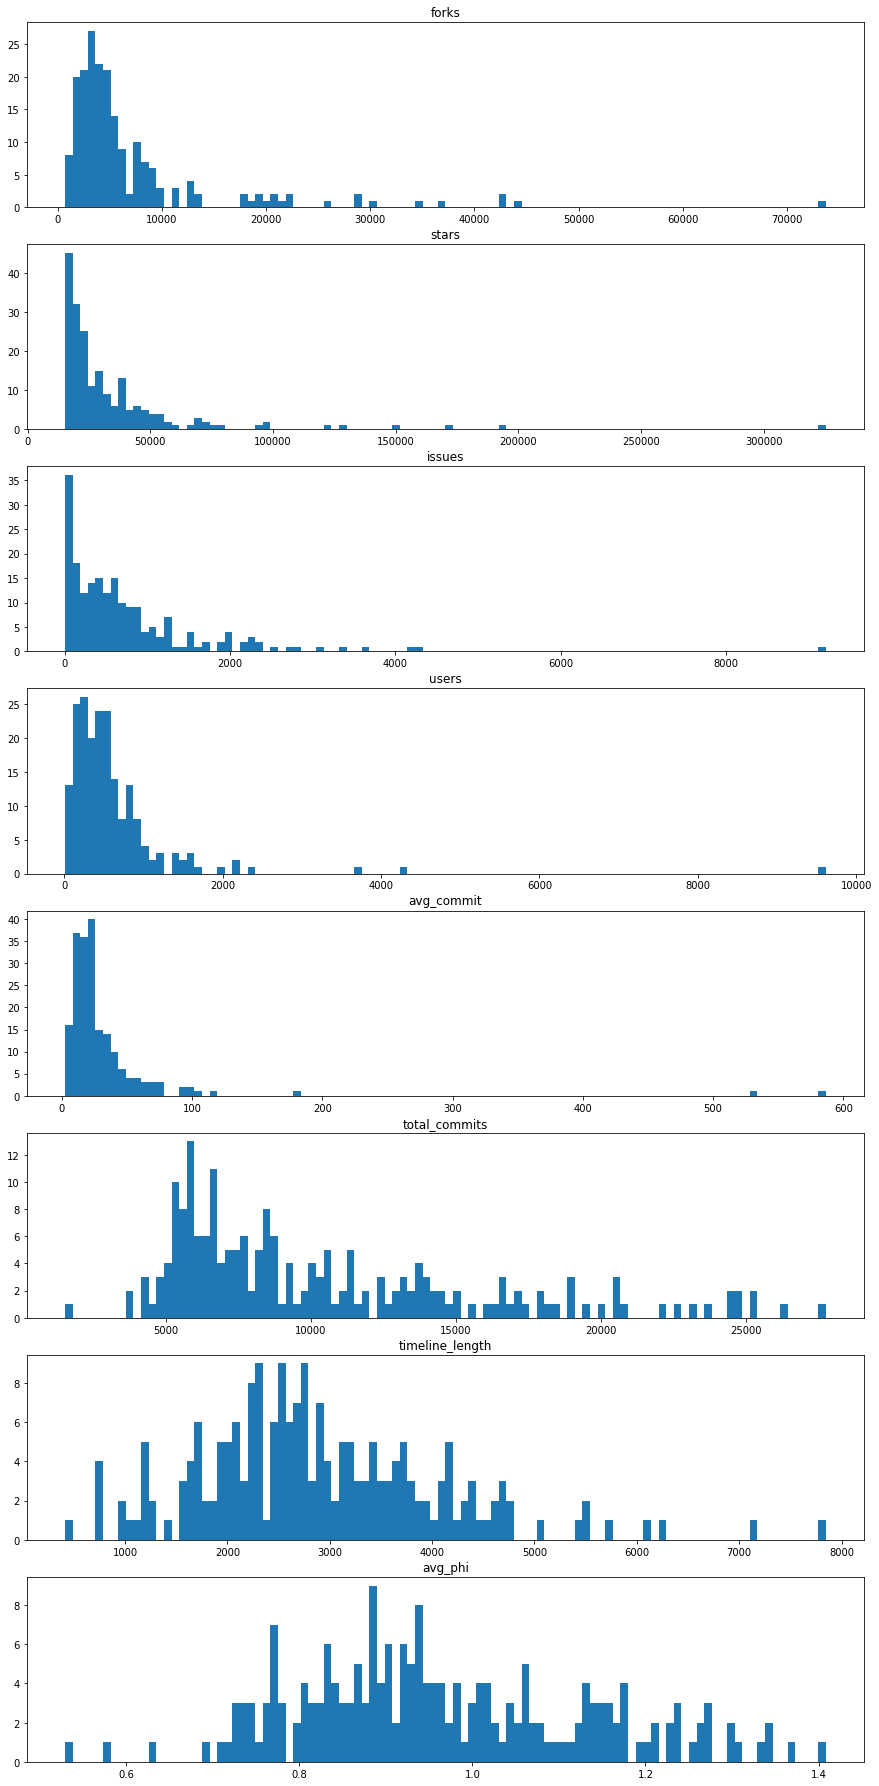

In [315]:
bins = 100
n = len(df.columns)

plt.figure(figsize=(15,n*4))
for i,col in enumerate(df.columns):
    plt.subplot(n,1,i+1)
    plt.title(col)
    plt.hist(df[col], bins)

plt.show()

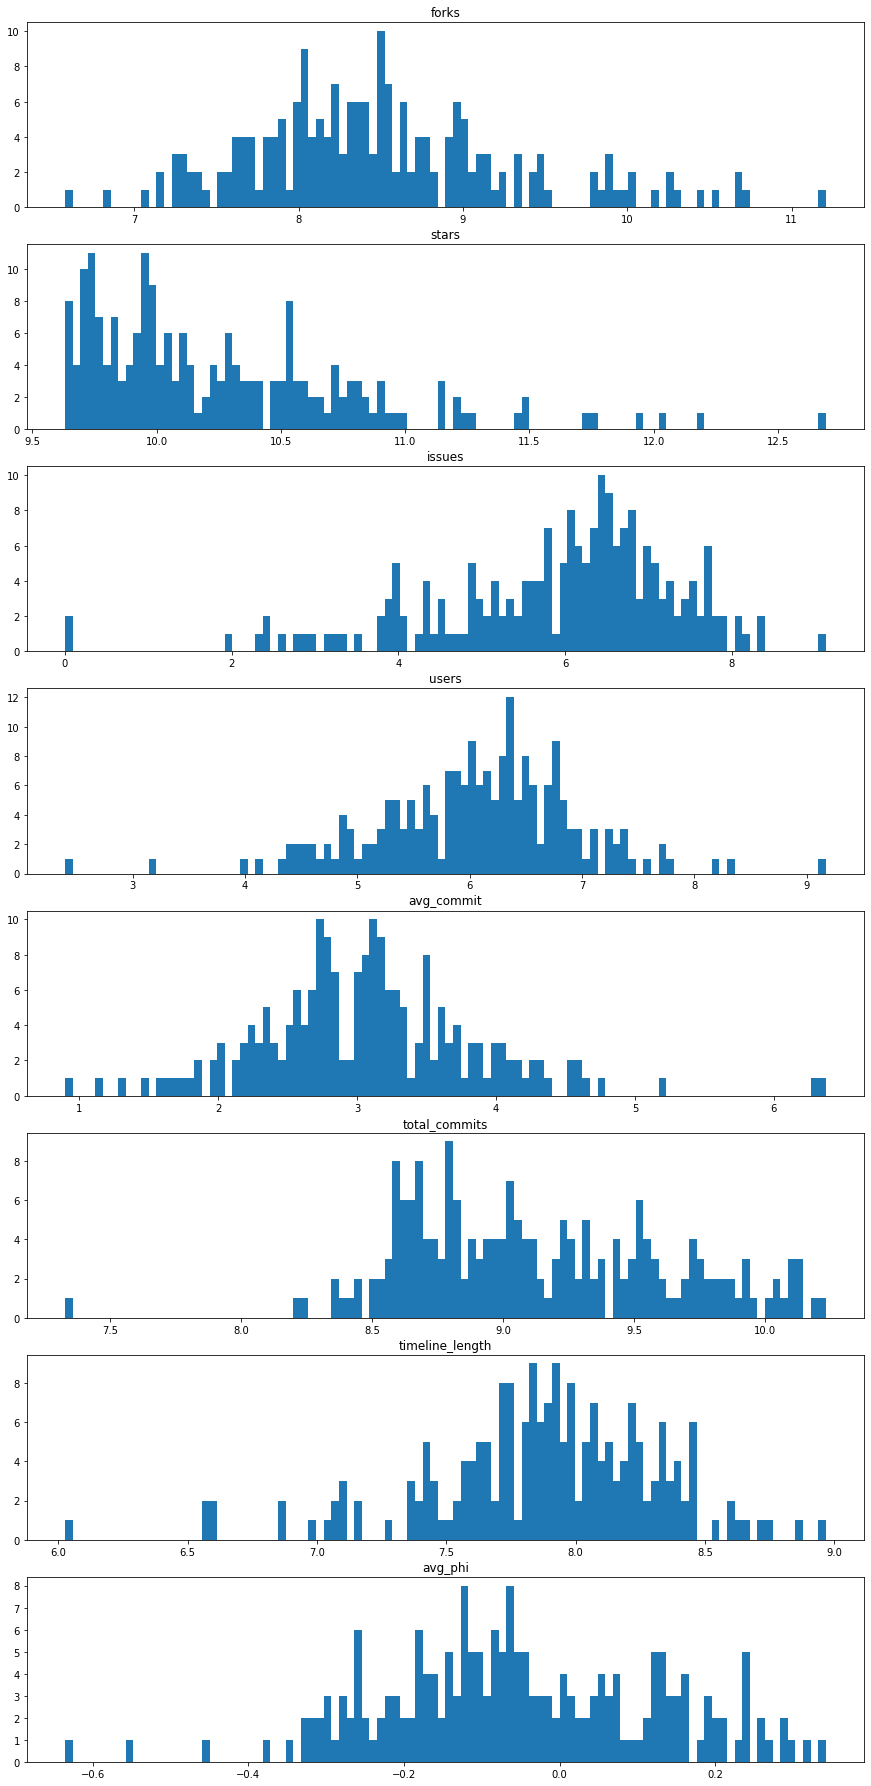

In [316]:
log_df = df.copy()
for col in log_df.columns:
    log_df = log_df[log_df[col] > 0]
    log_df[col] = np.log(log_df[col])
    
bins = 100
n = len(df.columns)

plt.figure(figsize=(15,n*4))
for i,col in enumerate(df.columns):
    plt.subplot(n,1,i+1)
    plt.title(col)
    plt.hist(log_df[col], bins)

plt.show()

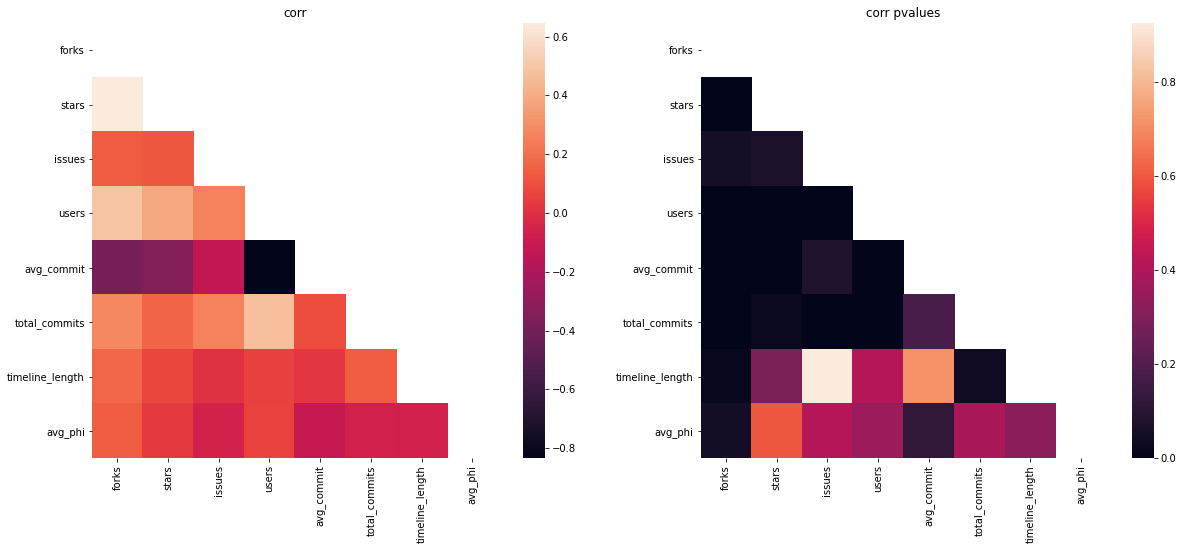

In [317]:
from scipy import stats as sci_stats
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('corr')
corrs = log_df.corr()
sns.heatmap(corrs, mask=np.triu(np.ones(df.shape[1])))

corr_tvals = corrs * np.sqrt(df.shape[0] - 2) / np.sqrt(1 - corrs**2)
corr_pvals = sci_stats.t.sf(np.abs(corr_tvals), df.shape[0] - 2)*2
corr_pvals = pd.DataFrame(corr_pvals, columns=df.columns, index=df.columns)


plt.subplot(1,2,2)
plt.title('corr pvalues')
sns.heatmap(corr_pvals, mask=np.triu(np.ones(df.shape[1])))

plt.show()

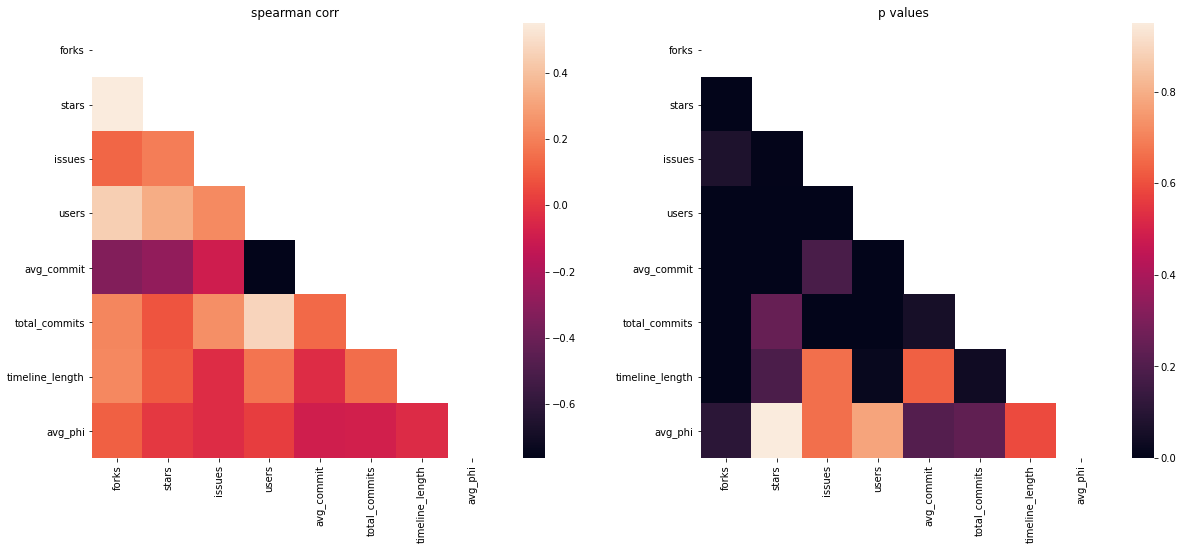

In [319]:
sp_cors = np.zeros(shape=(df.shape[1], df.shape[1]))
p_values = np.zeros(shape=(df.shape[1], df.shape[1]))
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        cor = sci_stats.spearmanr(log_df[df.columns[i]], log_df[df.columns[j]])
        sp_cors[i,j] = cor.correlation
        p_values[i,j] = cor.pvalue
sp_cors = pd.DataFrame(sp_cors, columns=df.columns, index=df.columns)
p_values = pd.DataFrame(p_values, columns=df.columns, index=df.columns)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('spearman corr')
sns.heatmap(sp_cors, mask=np.triu(np.ones(df.shape[1])))

plt.subplot(1,2,2)
plt.title('p values')
sns.heatmap(p_values, mask=np.triu(np.ones(df.shape[1])))

plt.show()

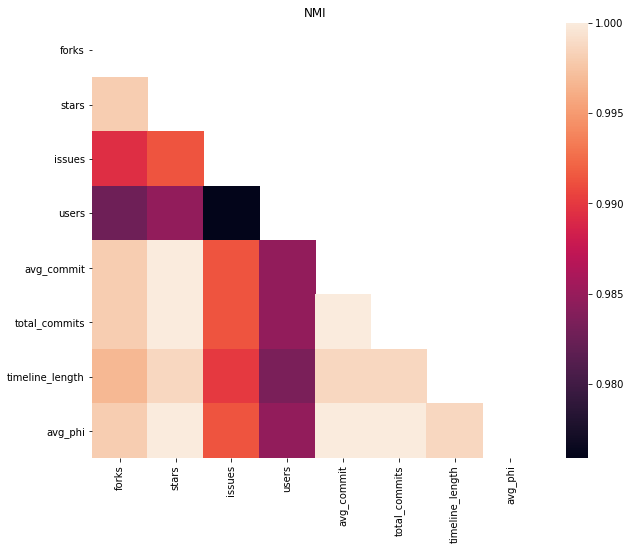

In [322]:
mis = np.zeros(shape=(df.shape[1], df.shape[1]))
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        mis[i,j] = normalized_mutual_info_score(df[df.columns[i]], df[df.columns[j]])
mis = pd.DataFrame(mis, columns=df.columns, index=df.columns)

plt.figure(figsize=(10,8))
plt.title('NMI')
sns.heatmap(mis, mask=np.triu(np.ones(df.shape[1])))
plt.show()

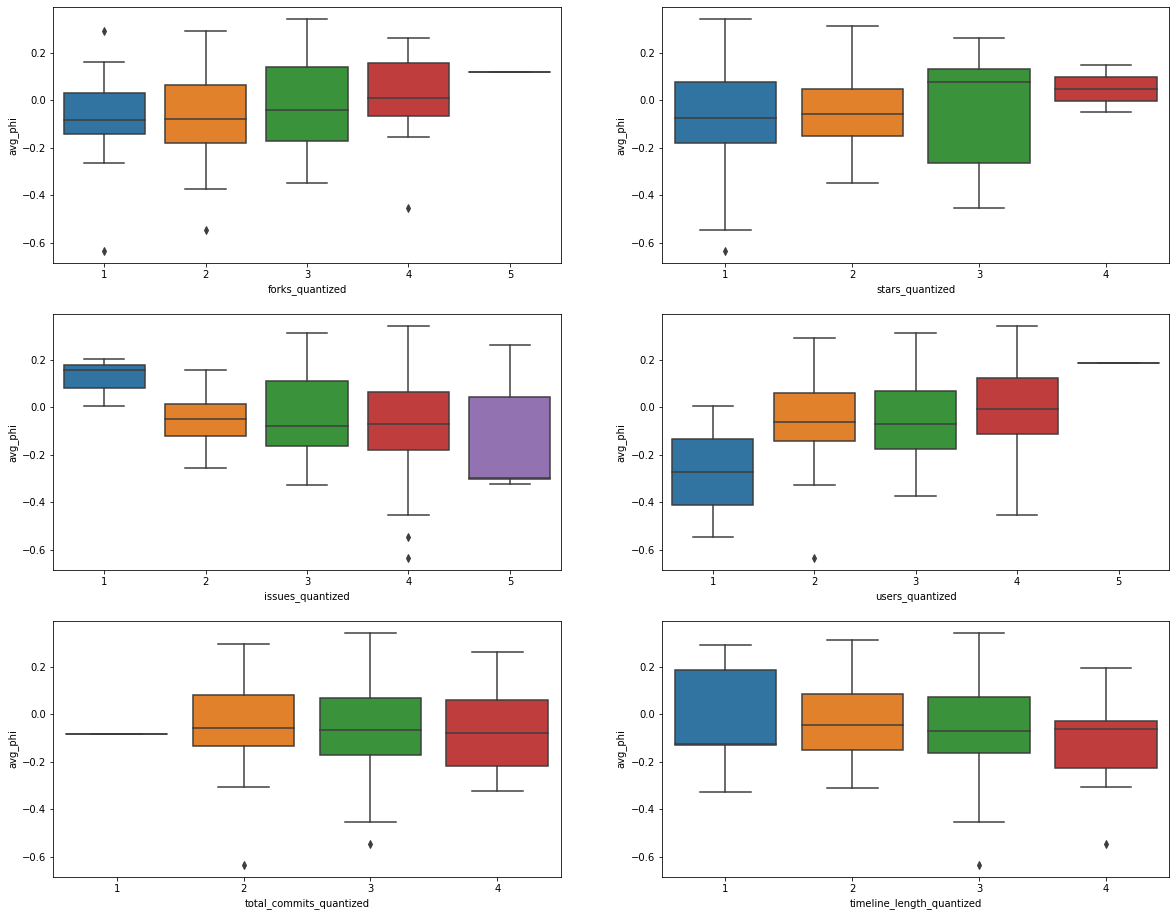

In [323]:
def quantize_col(data, col, n_bins=5):
    bins = np.linspace(np.min(data[col]), np.max(data[col])+1, n_bins+1)
    temp_df = data.copy()[[col, 'avg_phi']]
    temp_df[col+'_quantized'] = np.digitize(temp_df[col], bins=bins)   
    sns.boxplot(data=temp_df, x=col+'_quantized', y='avg_phi')

n = len(df.columns) - 1
plt.figure(figsize=(20,16))
for i,col in enumerate(df.drop(['avg_phi', 'avg_commit'], axis=1).columns):
    plt.subplot(n // 2 , 2, i+1)
    quantize_col(log_df, col, n_bins=5)
plt.show()

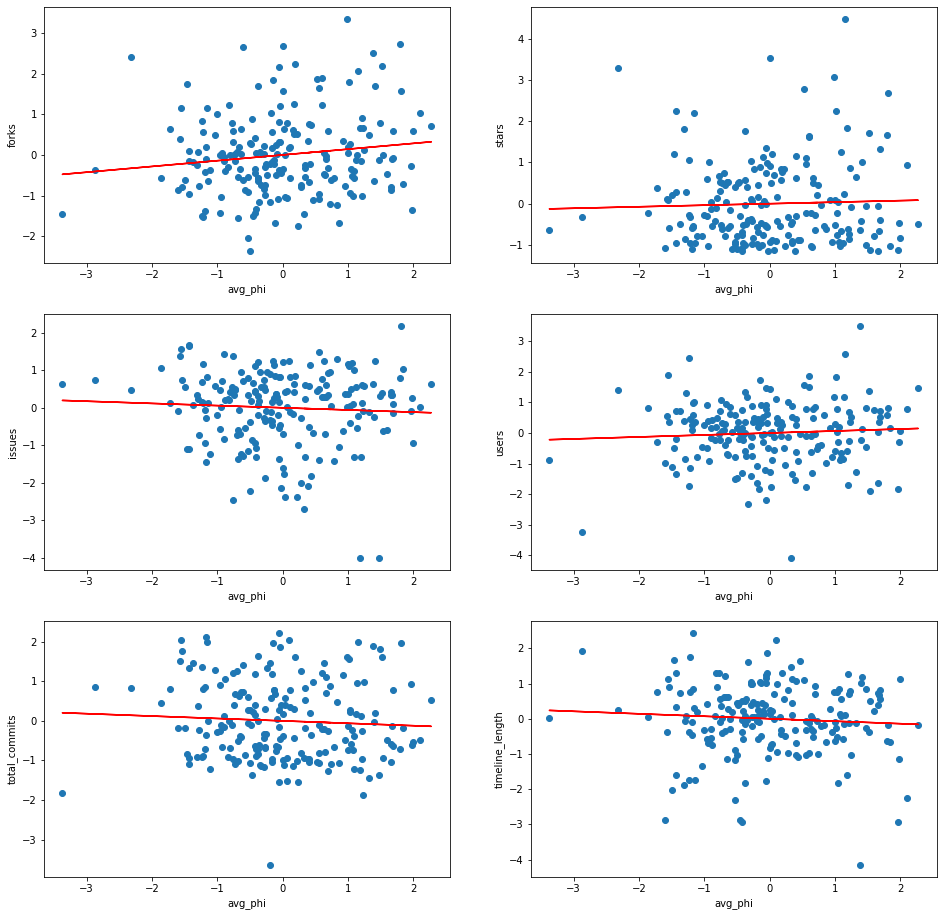

In [333]:
n = len(df.columns) - 1
standardize = lambda v : (v - v.mean()) / v.std()
x = standardize(log_df['avg_phi'].values)

plt.figure(figsize=(16,16))
for i,col in enumerate(df.drop(['avg_phi', 'avg_commit'], axis=1).columns):
    y = standardize(log_df[col].values)
    lr = LinearRegression().fit(x.reshape(-1,1),y)
    
    plt.subplot(n // 2, 2, i+1)
    plt.xlabel('avg_phi')
    plt.ylabel(col)
    plt.scatter(x=x, y=y)
    plt.plot(x, lr.predict(x.reshape(-1,1)), c='r')
    
plt.show()

In [325]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

scale = StandardScaler()

In [326]:
def experiment_regression(data, keys : list):
    X_drop = data.drop(['avg_phi', 'avg_commit'] + keys, axis=1).values
    X = data.drop(['avg_phi', 'avg_commit'], axis=1).values
    X = scale.fit_transform(X)
    X_drop = scale.fit_transform(X_drop)
    y = data['avg_phi'].values

    lr_drop = SVR(kernel='poly')
    lr = SVR(kernel='poly')
    lr.fit(X, y)
    lr_drop.fit(X_drop, y)

    r2 = lr.score(X, y)
    r2_dropped = lr_drop.score(X_drop, y)
    print('full:', r2)
    print('dropped:', r2_dropped)
    LRT = 2 * (np.log(r2) - np.log(r2_dropped))
    p_value = chi2.sf(LRT, 1)
    print('p value:', p_value)

    pred = lr.predict(X)
    pred_drop = lr_drop.predict(X_drop)

    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.title('full model')
    plt.plot(y)
    plt.plot(pred)

    plt.subplot(2,1,2)
    plt.title('restricted model')
    plt.plot(y)
    plt.plot(pred_drop)
    plt.show()

In [306]:
df.columns

Index(['forks', 'stars', 'issues', 'users', 'avg_commit', 'total_commits',
       'timeline_length', 'avg_phi'],
      dtype='object')

full: 0.2928041989412248
dropped: 0.18048733946297002
p value: 0.32525771821434385


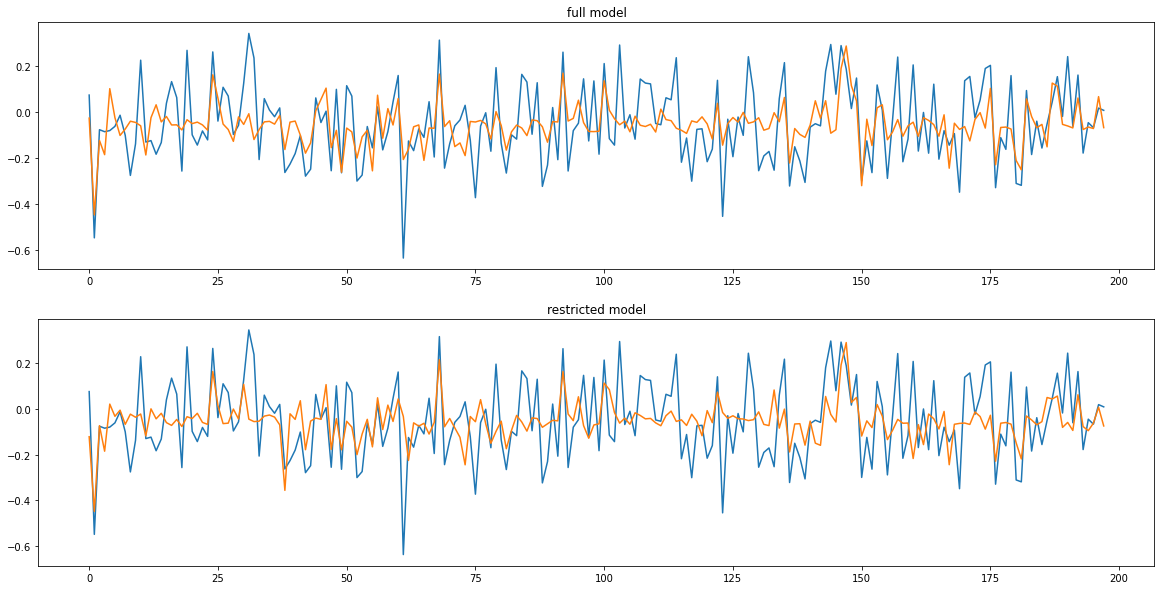

In [330]:
experiment_regression(log_df, keys=['issues'])